# Suite of Perception Experiments

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os

import numpy as np
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt
%matplotlib inline

import scipy

import warnings
warnings.filterwarnings("ignore")

import lqr
import linear_system as lin
import pipeline as pipe
import synthesis as synth
import training

In [3]:
### Dynamics
dt = 0.05
ndims = 2
nx = 2 * ndims
del_ref = 1

q = 5
norm = np.inf 

A, B, C = lin.double_integrator_dynamics(dt, ndims=ndims, q=None)
Q, R = lqr.lqr_parameters(q, ndims=ndims)
srQ = scipy.linalg.sqrtm(Q); srR = scipy.linalg.sqrtm(R)

K = lqr.lqr_inf_horizon(A, B, Q, R)[0]
Tmax = 200 # FIR horizon for SLS

### Observation
n_px = 48 # dim of image
dot_width = 0.06 # size of dot (between 0 and 1)
im_noise = 0.01 # percent noise (between 0 and 1)

In [4]:
def get_obs(xs): # xs is (N, nx)
    return np.array([pipe.loc2im((x[0], x[2]), n_px, dot_width, im_noise).flatten() for x in xs])

def get_traj_xs(x0, T, freq, amp, exp_noise):
    ref = np.zeros((T, x0.shape[0]))
    theta = np.linspace(0, freq*np.pi, T)
    ref[:,0] = amp * np.cos(theta)
    ref[:,2] = amp * np.sin(theta)
    xds = np.zeros(ref.shape)
    xds[0] = x0
    wds = np.random.standard_normal(ref.shape) * exp_noise # "exploration noise"
    for k in range(T-1):
        u = -K.dot(xds[k] - ref[k])
        xds[k+1] = A.dot(xds[k]) + B.dot(u) + wds[k]
    return xds, ref

def get_random_xs(T, r):
    return np.random.uniform(low=-r, high=r, size=(T, nx)), None

def get_xs(mode, params):
    return get_random_xs(**params) if mode == 'random' else get_traj_xs(**params)
    
def get_training_data(xs):
    return get_obs(xs), C.dot(xs.T).T

## Fitting Perception Module

### Comparing different Ps and their error models, ultimately to be used in control synthesis

We compare regularized ($\lambda = 10^{-3}$) with not regularizing. Our baseline is ridge regression.

Method:
- (To find the best $\lambda$): For a fixed $\alpha$, we successively train on train set, validate on test set. 
    - our objective is $\alpha \varepsilon_C + (1 - \alpha)\varepsilon_\eta$ 
- Once an adequately good $\lambda$ is found, train perception $p$ on entire train + test data.
- Fit the error model $p(z) = \Delta_C x + \eta$ using trained $p$ on the validation set.

Notes:
- Doing golden section search on $\lambda$ gives around $10^{-3}$; we choose this instead of refitting for every new dataset.
- There is an abrupt jump in optimal error model as we increase $\alpha$, where either the optimal $\varepsilon_C$ is essentially 0, or the optimal $\varepsilon_C$ is around 0.2

In [11]:
### Data
debug = False
save_data = False
rerun = False

T = 200
r = 0.25
freq = 6
amp = 0.3
exp_noise = 1.5e-2
x0 = np.array([0.4, 0, 0.1, 0])

param_dict = {
    'random': dict(T=T, r=r),
    'tracking': dict(x0=x0, T=T, freq=freq, amp=amp, exp_noise=exp_noise)
}

mode = 'tracking'

data_dir = 'data'
suffix = 'r_%.3f' % r if mode == 'random' else 'noise_%.3f' % exp_noise
data_fname = os.path.join(data_dir, '%s_training_%s.npz' % (mode, suffix))


## Generating/loading train/test data
if not rerun and os.path.exists(data_fname):
    print('loading data from', data_fname)
    data_dict = np.load(data_fname)
    ref = data_dict.get('ref', ref)
    xval = data_dict['xval']; zval = data_dict['zval']; 
    xhold = data_dict['xhold']; zhold = data_dict['zhold'];
    xtrain = data_dict['xtrain']; ztrain = data_dict['ztrain']; 
    xtest = data_dict['xtest']; ztest = data_dict['ztest'];
    xd, zd = np.vstack((xtrain, xtest)), np.vstack((ztrain, ztest))
else:
    xtrain, ref = get_xs(mode, param_dict[mode])
    xtest, _ = get_xs(mode, param_dict[mode])
    xval, _ = get_xs(mode, param_dict[mode])
    xhold, _ = get_xs(mode, param_dict[mode])

    ztrain, ytrain = get_training_data(xtrain)
    ztest, ytest = get_training_data(xtest)
    zval, yval = get_training_data(xval)
    zhold, yhold = get_training_data(xhold)

    xd, zd = np.vstack((xtrain, xtest)), np.vstack((ztrain, ztest))


if debug:
    pipe.plot_coordinate_data([xtrain, xtest, xval, xhold],
                             ['train', 'test', 'val', 'hold'])
    pipe.plot_image_data(zd, zval, n_px)

In [6]:
alpha = training.compute_alpha(xd, norm)
test_params = {
#     'smooth': dict(alpha=alpha, reg=2e-3, robust=True),
    'ridge': dict(alpha=alpha, reg=1e-4, robust=False)
}

Ps = {}; errs_tr = {}; errs_val = {};

if not rerun and os.path.exists(data_fname): # load saved models
    print('loading models from', data_fname)
    for name in test_params.keys():
        Ps[name] = data_dict['P_%s' % name]
        errs_tr[name] = data_dict['err_tr_%s' % name]
        errs_val[name] = data_dict['err_val_%s' % name]

In [7]:
for name, args in test_params.items():
    print(name, args)
    if name not in Ps:
        Ps[name] = training.train_P((xd, zd), C, **args)[0]
        errs_tr[name] = training.fit_error_model((xval, zval), C, Ps[name], args['alpha'])[1]
        errs_val[name] = training.fit_error_model((xhold, zhold), C, Ps[name], args['alpha'])[1]

    P = Ps[name]
    err_tr = errs_tr[name]
    err_val = errs_val[name]
    
    pnorm = np.linalg.norm(P, norm)
    print("eps_C train: {}, |P|: {}".format(err_tr[0], pnorm))
    print("eps_C val: {}, |P|: {}".format(err_val[0], pnorm))

ridge {'alpha': 0.2906643719055043, 'reg': 0.0001, 'robust': False}
alpha: 0.2906643719055043, reg: 0.0001
eps_C train: 0.05288290479817753, |P|: 7.99451590703735
eps_C val: -2.915035626344059e-11, |P|: 7.99451590703735


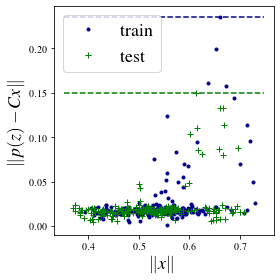

In [34]:
# plot data
for i, name in enumerate(test_params.keys()):
    P = Ps[name]
    datasets = [
        dict(x=xval, y=zval.dot(P.T), label='train', marker='.', color='darkblue'),
        dict(x=xhold, y=zhold.dot(P.T), label='test', marker='+', color='green'),
    ]
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    pipe.plot_err_vs_norm(ax, datasets, errs_val[name], C)
    fig.tight_layout()

In [13]:
if save_data:
    print('saving data to %s' % data_fname)
    data_dict = {'xtrain': xtrain, 'ztrain': ztrain,
                 'xtest': xtest, 'ztest': ztest,
                 'xval': xval, 'zval': zval, 
                 'xhold': xhold, 'zhold': zhold,
                 'ref': ref}
    for name in test_params.keys():
        data_dict['P_%s' % name] = Ps[name]
        data_dict['err_tr_%s' % name] = errs_tr[name]
        data_dict['err_val_%s ' % name] = errs_val[name]
    np.savez(data_fname, **data_dict)

## Control synthesis

In [17]:
## Synthesize controllers

rerun = False
save_rollouts = False

sx = 0.5
sy = 0.5

controllers = {}
control_params = {
    'L1 robust': dict(T=200, norm='l1', wx=sx, wy=sy, 
                      Ld=0.5, wc=0.1, solver='MOSEK'),
    'LQG robust': dict(T=200, norm='h2', wx=sx, wy=sy,
                      Ld=0.2, wc=0.04, solver='MOSEK'),
    'L1 nominal': dict(T=200, norm='h2', wx=sx, wy=sy,
                      Ld=None, wc=None),
    'LQG nominal': dict(T=200, norm='l1', wx=sx, wy=sy,
                       Ld=None, wc=None),
}

param_str = '_'.join([('%s_%.1f_%.2f_%d' % (ps['norm'], ps['Ld'], ps['wc'], ps['T']))\
                      for name, ps in control_params.items() if 'robust' in name])
sys_fname = 'data/controllers_%.2f_%.2f_%s.npz' % (sx, sy, param_str)

if not rerun and os.path.exists(sys_fname):
    controllers = pipe.load_system(sys_fname, A)

for name, params in control_params.items():
    if name in controllers:
        continue
    sys, prob = synth.synthesize_perception_controller(A, B, C, Q, R, **params)
    controllers[name] = sys
    print(name, prob)

L1 robust (array(224.272), 'optimal')
using l1 of transpose instead of h inf norm
LQG robust (872.5921086686766, 'optimal')
L1 nominal (346.5969479655226, 'optimal')
LQG nominal (array(71.332), 'optimal')


In [18]:
def proc_fnc(x, u):
    wx = np.sign(B.dot(u)) * sx if mode == 'random' else 0
    return A.dot(x) + B.dot(u) + wx

def obs_fnc_generator(P):
    def obs_fnc(x):
        z = get_obs([x])
        y = z.dot(P.T).flatten()
        return y, z
    return obs_fnc

In [19]:
T = 150 # number of timesteps to simulate
n_rollouts = 200

if mode is 'tracking':
    start_noise = 1e-1
    x0s = np.clip(xval[0] + start_noise * np.random.standard_normal((n_rollouts, A.shape[0])), -0.48, 0.48)
    ref = ref
else:
    start_noise = r*1.6
    x0s, ref = get_random_xs(n_rollouts, start_noise)

rollout_fname = os.path.join(data_dir, '%s_%drollouts_startnoise_%.2f.npz' % (mode, n_rollouts, start_noise))

all_rollouts = {}

if not rerun and os.path.exists(rollout_fname):
    print('loading rollouts')
    all_rollouts = pipe.load_rollouts(rollout_fname, skip_rollout)
else:     
    print('running rollouts')
    for name in test_params.keys():
        obs_fnc = obs_fnc_generator(Ps[name])
        all_rollouts[name] = pipe.run_rollouts(controllers, A, B, C, T, x0s, ref, proc_fnc, obs_fnc)

running rollouts


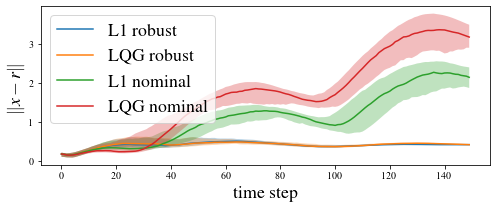

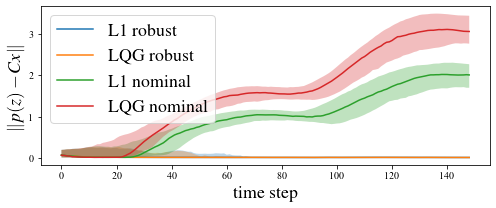

In [31]:
figs = {}
no_plot = []

figsize = (7, 3)
for name, rollouts in all_rollouts.items():
    fig1, fig2 = pipe.plot_rollouts(rollouts, C, ref, figsize=figsize, skip_keys=no_plot)

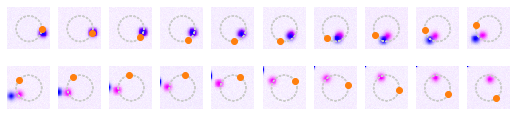

In [26]:
start = 0
step = 4
end = 8*10
for name, rollouts in all_rollouts.items(): # for each perception map
    z_h2r = rollouts['L1 robust']['zs'][0]
    z_h2 = rollouts['L1 nominal']['zs'][0]
    fig = plt.figure(figsize=(9, 2))
    pipe.plot_image_rollouts(fig, z_h2, z_h2r, ref, n_px, start, step, end)